# Import libs

In [1]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sys

sys.path.append('..')
from eFlow.ClusterMaster import *
from eFlow.DataFrameTypes import *
from eFlow.DataAnalysis import *
from eFlow.DataCleaner import *
from xgboost import XGBClassifier
import ipython_blocking
from pivottablejs import pivot_ui

In [2]:
%matplotlib notebook
%matplotlib inline

### Be sure to run the following

## Declare Worflow Variables

#### (This should be the only place you should have to declare anything)

In [3]:
dataset_path = "Datasets/titanic_train.csv"
target_column = "Survived"
parent_project_name = "Pre processing"

# Import dataset

In [4]:
df = pd.read_csv(dataset_path)
display(df.shape)
df.head()

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Interaction tool for dataframes

### Explore the data

In [5]:
pivot_ui(df,
         outfile_path='Piviot_Table_JS.html')

In [6]:
df[target_column]

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [7]:
# w = widgets.SelectMultiple(
#     options=['Apples', 'Oranges', 'Pears'],
#     value=['Oranges'],
#     #rows=10,
#     description='Fruits',
#     disabled=False
# )
# del w

In [8]:
a = str(u"\u2192")
print(a)

→


## Remove Un-Wanted Columns

### Do not remove nans yet, let the datacleaner do it's job

In [9]:
df.drop(columns=["Name",
                 "Ticket",
                 "PassengerId"],
        inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [10]:
from dateutil import parser
dt = parser.parse("Aug 28 1999 12:00AM")

In [11]:
df["Date_test"] = ["2019-01-02" for _ in range(0,df.shape[0])]
df["Date_test"][0] = np.nan
# df["Date_test"] = [parser.parse(val)for val in df["Date_test"].value_counts().keys()]

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Basic Feature manipulation

### Change cabin column to have the level on the ship

In [12]:
df["Cabin"] = df["Cabin"].str.replace(r'\d+', '').str[0]

## Change Feature Data types

### Look at data types

In [13]:
df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

### Make given data type changes

In [14]:
df["Pclass"] = df["Pclass"].replace(1, np.nan)

### Final look at data types

In [15]:
df.dtypes

Survived       int64
Pclass       float64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

## Set up DataFrameTypes

In [16]:
df_features = DataFrameTypes(df,
                             target_column=target_column,
                             ignore_nulls=True)

Categorical Features: {'Cabin', 'Sex', 'Embarked'}

Possible One hot encoded feature names: {'Cabin': ['Cabin_A', 'Cabin_F', 'Cabin_G', 'Cabin_C', 'Cabin_E', 'Cabin_T', 'Cabin_D', 'Cabin_B'], 'Sex': ['Sex_male', 'Sex_female'], 'Embarked': ['Embarked_Q', 'Embarked_S', 'Embarked_C']}

------------------------------------------------------------------------------------------
Numerical Features: {'Survived', 'SibSp', 'Fare', 'Parch', 'Pclass', 'Age'}

Integer Features: {'Parch', 'Survived', 'Pclass', 'SibSp'}

Float Features: {'Fare', 'Age'}

Datetime Features: {'Date_test'}

Target Feature: Survived



## Skim through Value Counts

In [17]:
for col in df.columns:
    if col not in df_features.get_float_features() and len(np.unique(df[col].dropna().values)) <= 12:
        display(df[col].value_counts())
        print("***" * 4 + "\n\n")

0    549
1    342
Name: Survived, dtype: int64

************




3.0    491
2.0    184
Name: Pclass, dtype: int64

************




male      577
female    314
Name: Sex, dtype: int64

************




0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

************




0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

************




C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

************




S    644
C    168
Q     77
Name: Embarked, dtype: int64

************




2019-01-02    890
Name: Date_test, dtype: int64

************




### Perform quick analysis

/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/General Analysis (Before Cleaning)/
********************************************************************************




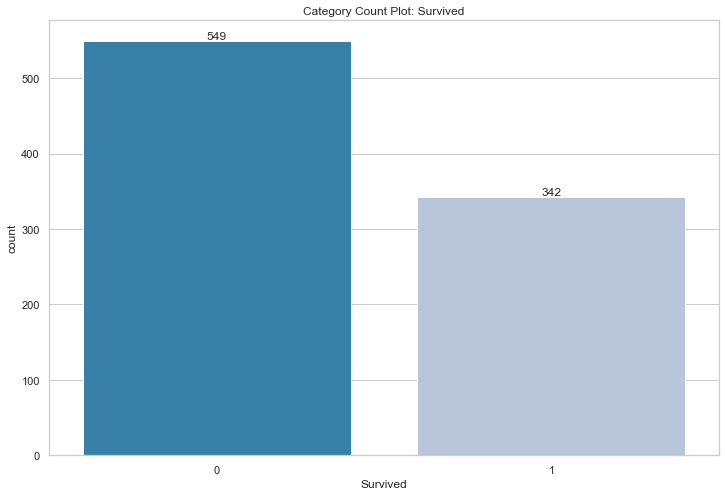

,Unique Values,Counts
0,0,549
1,1,342






--------------------------------------------------------------------------------




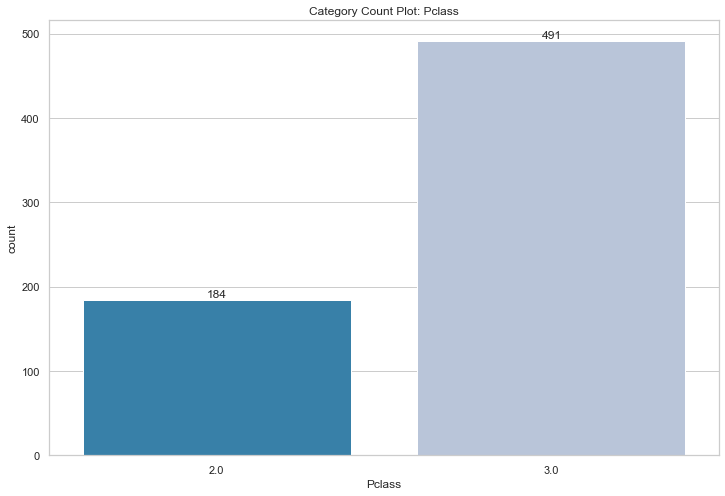

,Unique Values,Counts
0,3.0,491
1,2.0,184






--------------------------------------------------------------------------------




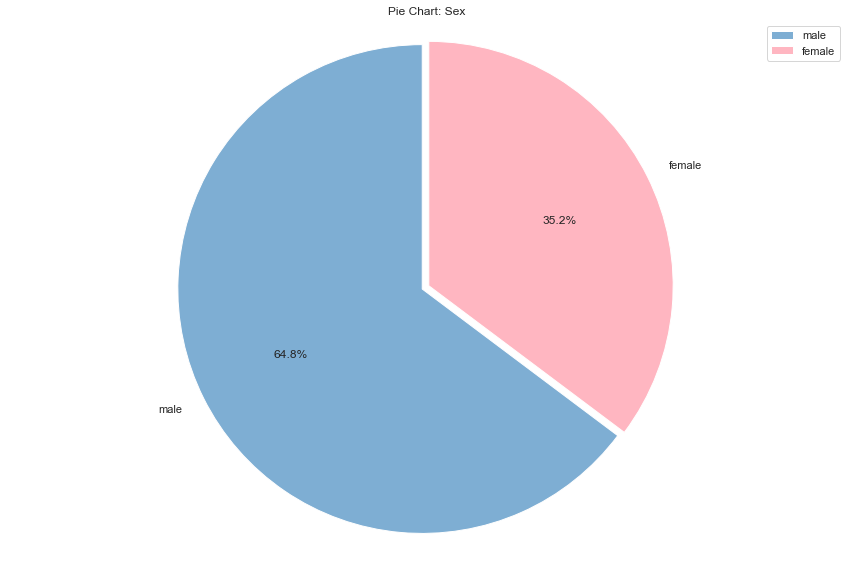

<Figure size 1440x1440 with 0 Axes>

,Unique Values,Counts
0,male,577
1,female,314






--------------------------------------------------------------------------------




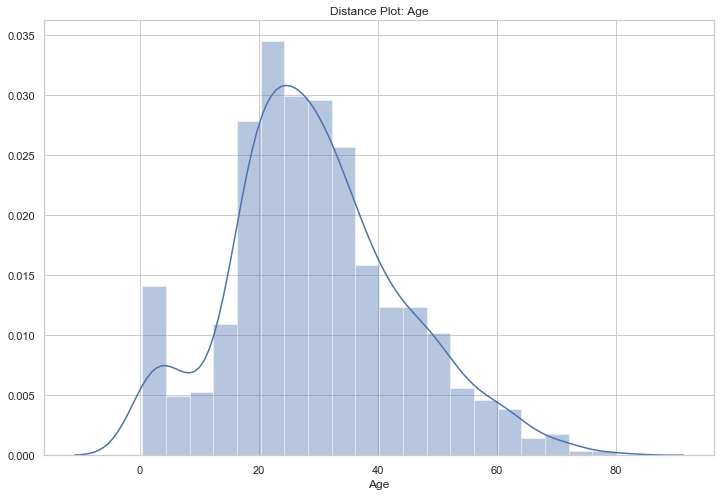

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000
var,211.019125






--------------------------------------------------------------------------------




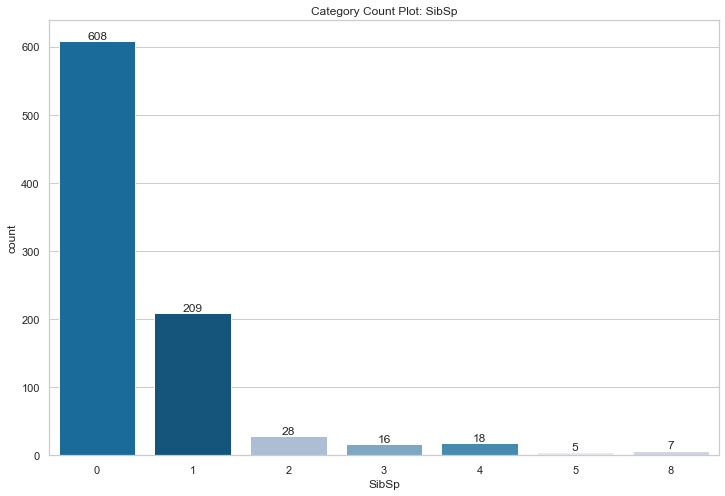

,Unique Values,Counts
0,0,608
1,1,209
2,2,28
3,4,18
4,3,16
5,8,7
6,5,5






--------------------------------------------------------------------------------




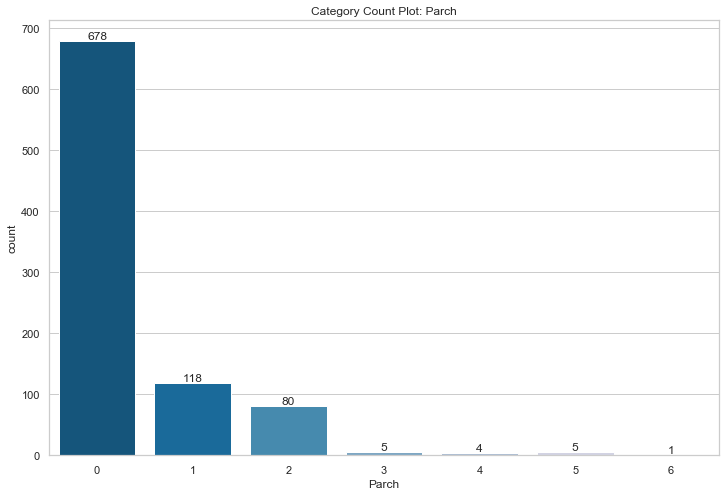

,Unique Values,Counts
0,0,678
1,1,118
2,2,80
3,5,5
4,3,5
5,4,4
6,6,1






--------------------------------------------------------------------------------




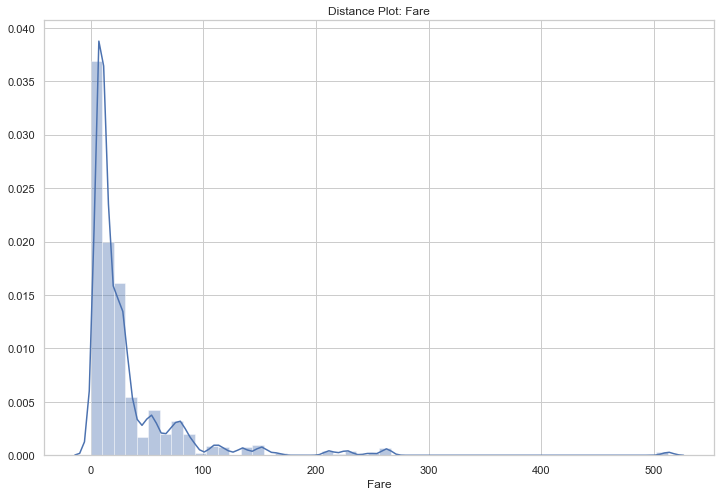

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200
var,2469.436846






--------------------------------------------------------------------------------




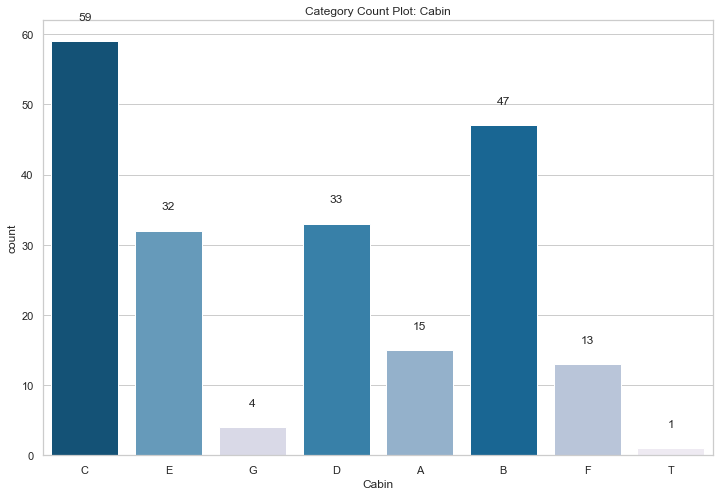

,Unique Values,Counts
0,C,59
1,B,47
2,D,33
3,E,32
4,A,15
5,F,13
6,G,4
7,T,1






--------------------------------------------------------------------------------




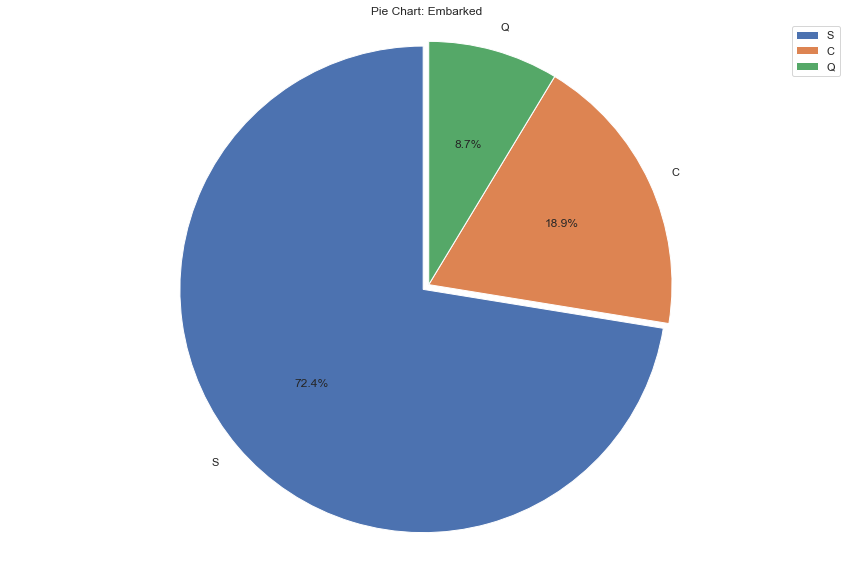

<Figure size 1440x1440 with 0 Axes>

,Unique Values,Counts
0,S,644
1,C,168
2,Q,77






--------------------------------------------------------------------------------




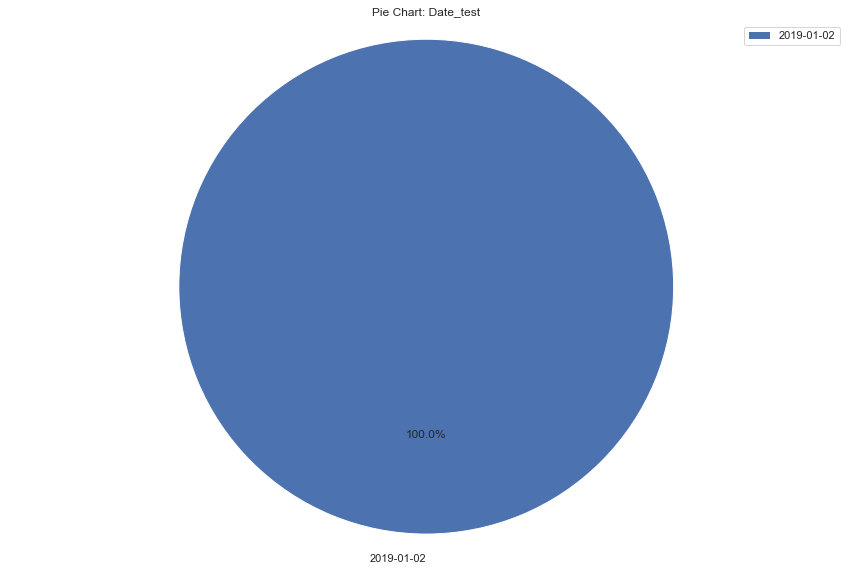

<Figure size 1440x1440 with 0 Axes>

,Unique Values,Counts
0,2019-01-02,890






--------------------------------------------------------------------------------




In [18]:
analysis_obj = DataAnalysis(df,
                            df_features,
                            project_name=parent_project_name + "/" + "General Analysis (Before Cleaning)",
                            missing_data_visuals=False)

In [19]:
df["Pclass"].value_counts().keys()

Float64Index([3.0, 2.0], dtype='float64')

## Data Cleaning

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Pclass,216,24.2
Age,177,19.9
Embarked,2,0.2
Date_test,1,0.1


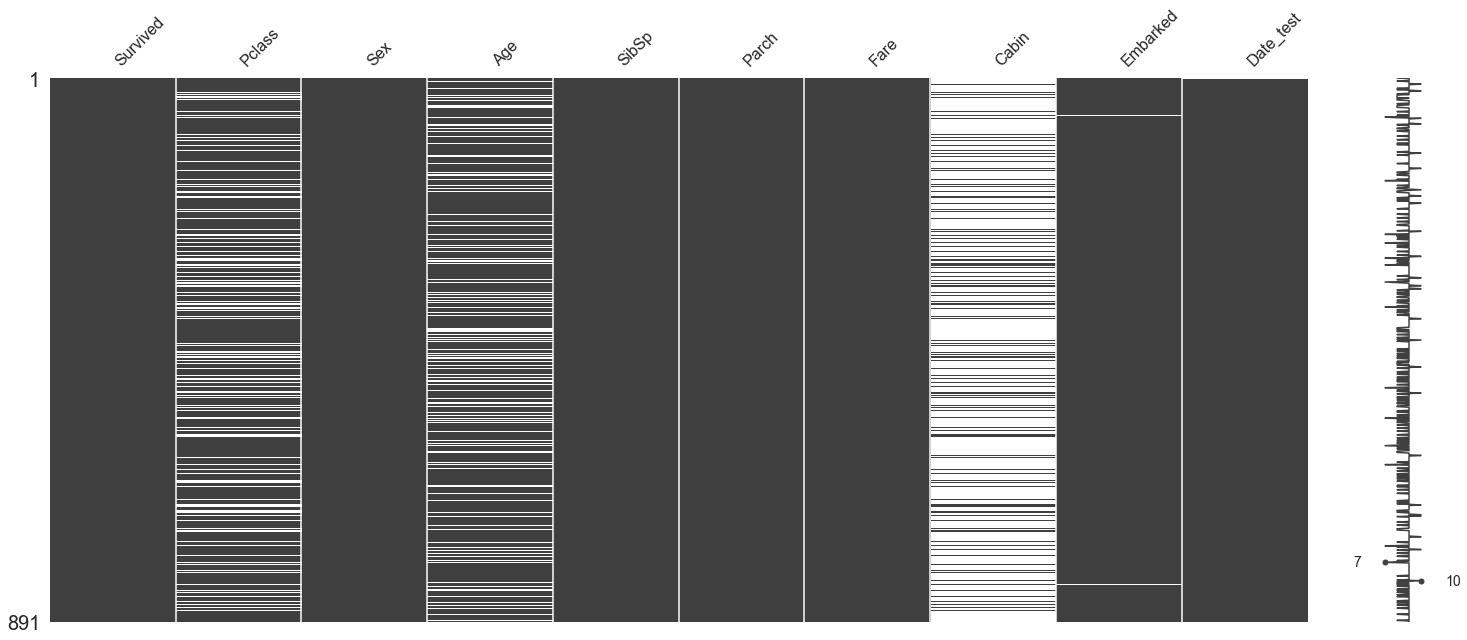

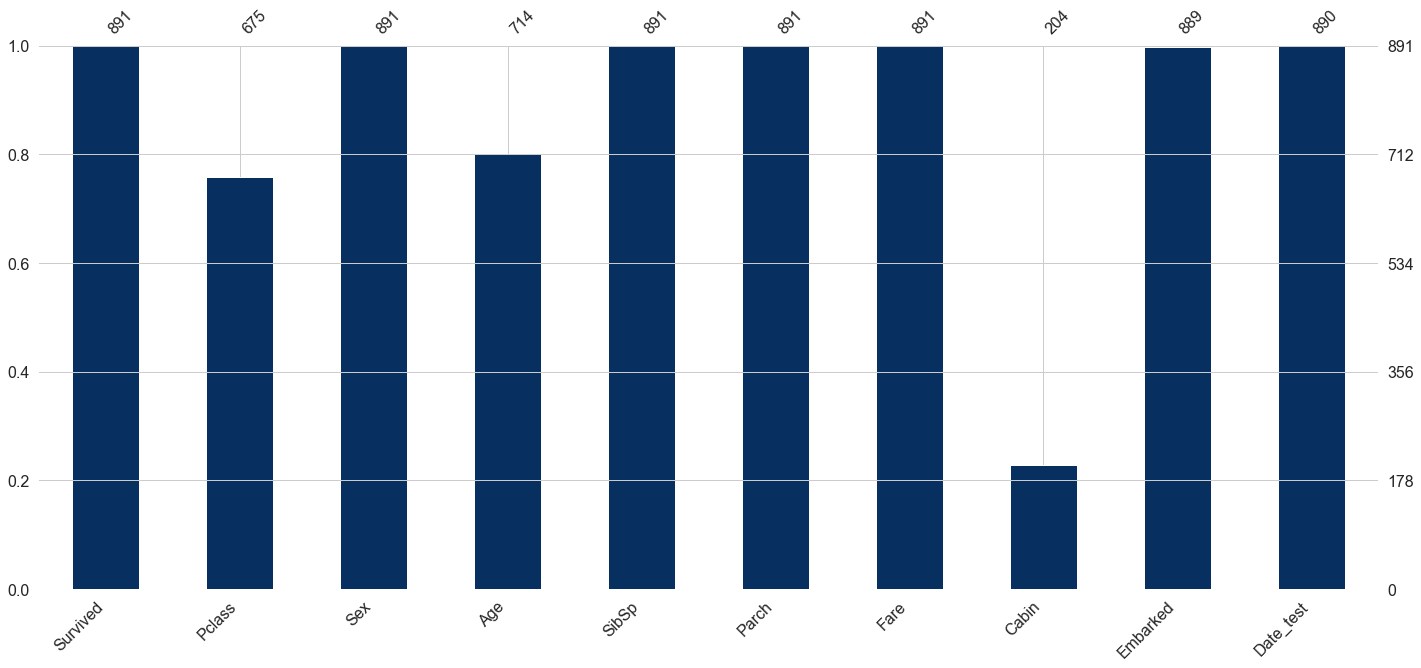

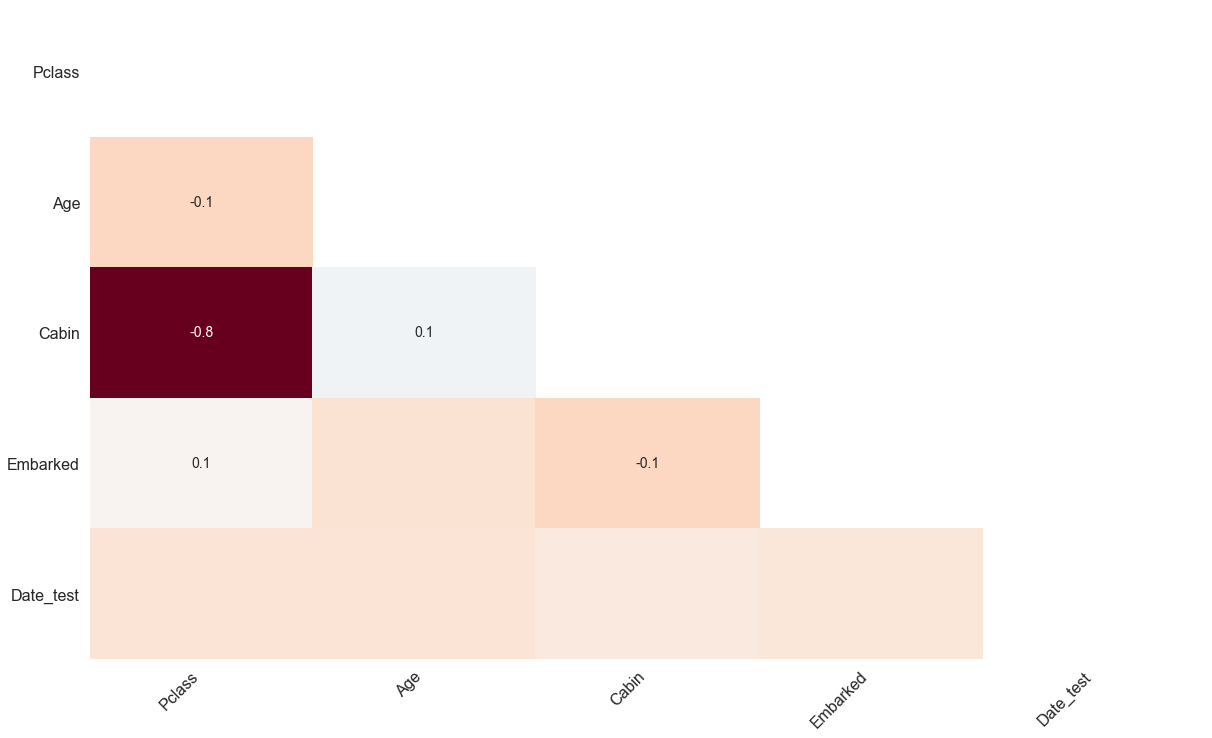

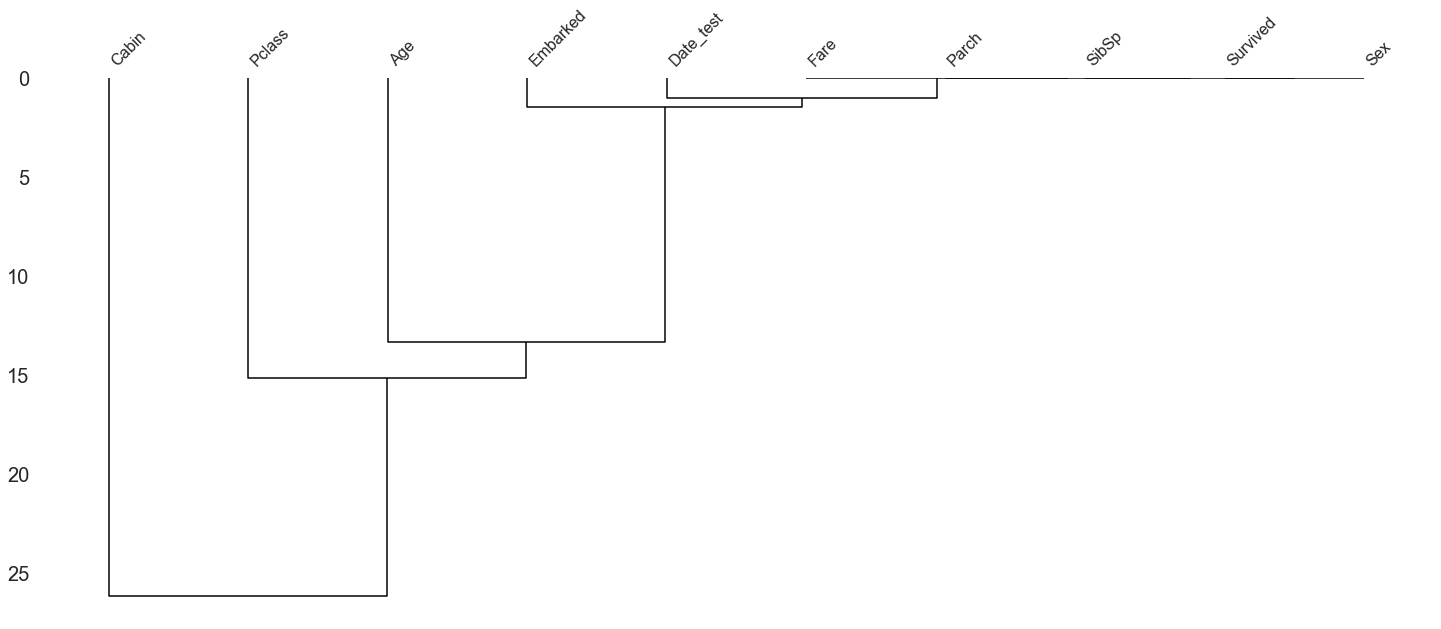

/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/Data Cleaning/
Hit


In [20]:
data_cleaner = DataCleaner(df,
                           project_name=parent_project_name + "/" + "Data Cleaning",
                           missing_data_visuals=True)

In [21]:
data_cleaner.init_json_file_name("test.json")

In [22]:
data_cleaner.data_cleaning_widget(df,
                                  df_features)

Text(value='Default Data Cleaning', description='File Name:', layout=Layout(left='590px'), placeholder='Replac…

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('Pcl…

Button(description='Create JSON File from options', layout=Layout(bottom='5px', left='100px', width='40%'), st…

In [23]:
data_cleaner.get_last_saved_json_file_path()

AttributeError: 'DataCleaner' object has no attribute 'get_last_saved_json_file_path'

In [ ]:
data_cleaner.data_cleaning_with_json_file(df,
                                          data_cleaner.get_last_saved_json_file_path())

In [ ]:
from scipy import stats
df.reset_index(drop=True)
z_score_return = stats.zscore(((df["Age"].dropna())))
df["Age"].dropna()[(z_score_return >= -2) & (z_score_return <= 2)]

In [ ]:
from impyute.imputation.cs import mice

a = df["Age"].tolist()
# start the MICE training
imputed_training=mice(df.values)

In [ ]:
import datawig

df_train, df_test = datawig.utils.random_split(df)

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
    output_column= 'Age', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df, num_epochs=200)




In [ ]:
imputed_training=mice(df[df_features.get_numerical_features()].values)
imputed_training[0]

In [ ]:
!pip install datawig

In [ ]:
file_name = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/General Analysis (Before Cleaning)/Feature Analysis/Tables/Descriptions/Fare_Descr.png"

In [ ]:
from PIL import Image
from PIL import ImageEnhance
 
def adjust_sharpness(input_image, output_image, factor):
    image = Image.open(input_image)
    enhancer_object = ImageEnhance.Sharpness(image)
    out = enhancer_object.enhance(factor)
    out.save(output_image)
 
if __name__ == '__main__':
    adjust_sharpness(file_name,
                     file_name,
                    1.7)

In [ ]:
# !pip install opencv-python
# !pip install Pillow
# !pip install tesserocr